<a href="https://colab.research.google.com/github/bindu172424/Negation-assisted-emotion-detection-from-text-data/blob/main/third_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Data Collection and Gathering

def load_data(path):
    texts, labels = [], []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if ";" in line:
                text, label = line.strip().rsplit(";", 1)
                texts.append(text)
                labels.append(label)
    return texts, labels

train_texts, train_labels = load_data("/content/train.txt")
val_texts, val_labels     = load_data("/content/val.txt")
test_texts, test_labels   = load_data("/content/test.txt")

print("Train:", len(train_texts))
print("Validation:", len(val_texts))
print("Test:", len(test_texts))


Train: 16000
Validation: 2000
Test: 2000


**Data Loading**
This code reads text data line by line from files and separates each tweet and its label using ;, storing them in two lists (texts and labels).

**Train / Validation / Test Splitting**
The dataset is already split into training, validation, and test files to avoid data leakage and to properly evaluate the model on unseen data.

**Why Early Splitting**
Splitting early ensures the model does not memorize data and gives a true measure of performance during training and final testing.

**Text–Label Mapping**
Each text is correctly paired with its emotion label, which is required for supervised learning.

**What is Encoding (utf-8)**
Encoding defines how text is read by the computer.
utf-8 allows reading emojis, special characters, and different languages correctly, which is very important for Twitter data.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)   # remove punctuation & numbers
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)


In [ ]:
# Keep original copy
original_texts = train_texts[:5]

# Apply preprocessing
processed_texts = [preprocess_text(t) for t in original_texts]

print("TEXT PREPROCESSING COMPARISON\n")

for i in range(5):
    print(f"Row {i+1}")
    print("Before :", original_texts[i])
    print("After  :", processed_texts[i])
    print("-" * 70)


TEXT PREPROCESSING COMPARISON

Row 1
Before : i didnt feel humiliated
After  : didnt feel humiliated
----------------------------------------------------------------------
Row 2
Before : i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
After  : go feeling hopeless damned hopeful around someone care awake
----------------------------------------------------------------------
Row 3
Before : im grabbing a minute to post i feel greedy wrong
After  : im grabbing minute post feel greedy wrong
----------------------------------------------------------------------
Row 4
Before : i am ever feeling nostalgic about the fireplace i will know that it is still on the property
After  : ever feeling nostalgic fireplace know still property
----------------------------------------------------------------------
Row 5
Before : i am feeling grouchy
After  : feeling grouchy
----------------------------------------------------------------------


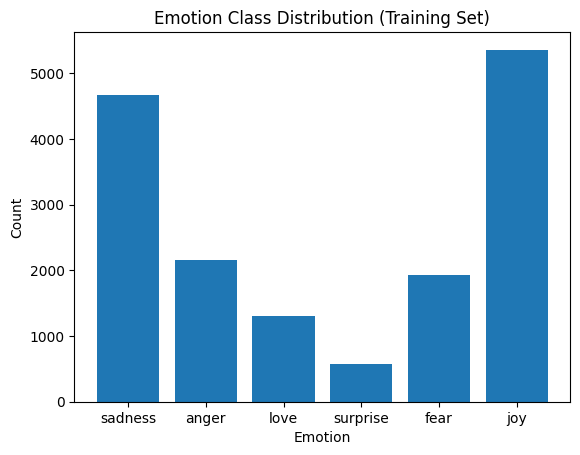

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

label_counts = Counter(train_labels)

plt.bar(label_counts.keys(), label_counts.values())
plt.title("Emotion Class Distribution (Training Set)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()


In [ ]:
## STEP 4: Feature Engineering (Negation-Aware Preprocessing)

import re

NEGATIONS = {
    "not","no","never","none","nobody","nothing","neither","nowhere",
    "hardly","scarcely","barely",
    "isn't","isnt","wasn't","wasnt","aren't","arent","weren't","werent",
    "don't","dont","doesn't","doesnt","didn't","didnt",
    "can't","cant","couldn't","couldnt","won't","wont"
}


def negation_aware_text(sentence):
    words = re.findall(r"\w+|[^\w\s]", sentence)
    transformed = []
    negate = False

    for word in words:
        if word in NEGATIONS:
            negate = True
            transformed.append(word)
        elif negate and word.isalpha():
            transformed.append("NEG_" + word)
            negate = False
        else:
            transformed.append(word)

    return " ".join(transformed)

train_texts_neg = [negation_aware_text(t) for t in train_texts]
val_texts_neg   = [negation_aware_text(t) for t in val_texts]
test_texts_neg  = [negation_aware_text(t) for t in test_texts]

print("Original:", train_texts[0])
print("Negation-aware:", train_texts_neg[0])


Original: i didnt feel humiliated
Negation-aware: i didnt NEG_feel humiliated


In [ ]:
# show 5 dataset examples with negation explanation

for i in range(5):
    print(f"Example {i+1}")
    print("Original:", train_texts[i])
    print("Negation-aware:", train_texts_neg[i])

    if any(n in train_texts[i] for n in NEGATIONS):
        print("Why NEG_ appears: sentence contains a negation word, so the emotion-bearing word after it is marked.")
    else:
        print("Why no NEG_: sentence contains no negation word.")

    print("-" * 60)


Example 1
Original: i didnt feel humiliated
Negation-aware: i didnt NEG_feel humiliated
Why NEG_ appears: sentence contains a negation word, so the emotion-bearing word after it is marked.
------------------------------------------------------------
Example 2
Original: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Negation-aware: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Why no NEG_: sentence contains no negation word.
------------------------------------------------------------
Example 3
Original: im grabbing a minute to post i feel greedy wrong
Negation-aware: im grabbing a minute to post i feel greedy wrong
Why no NEG_: sentence contains no negation word.
------------------------------------------------------------
Example 4
Original: i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Negation-aware: i am ever fee

In [ ]:
# STEP 5: Label Encoding

label2id = {
    "sadness":0,"joy":1,"anger":2,"fear":3,"love":4,"surprise":5
}
id2label = {v:k for k,v in label2id.items()}

train_labels_enc = [label2id[l] for l in train_labels]
val_labels_enc   = [label2id[l] for l in val_labels]
test_labels_enc  = [label2id[l] for l in test_labels]


In [ ]:
# STEP 6: Tokenization

from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

print(tokenizer(train_texts_neg[0]))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

{'input_ids': [101, 1045, 2134, 2102, 11265, 2290, 1035, 2514, 26608, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
# STEP 7: Model Training and Selection

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertForSequenceClassification

class EmotionDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts, truncation=True, padding=True, max_length=128
        )
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds = EmotionDataset(train_texts_neg, train_labels_enc)
val_ds   = EmotionDataset(val_texts_neg, val_labels_enc)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=6
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# STEP 7: Model Training and Selection (FIXED)

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertForSequenceClassification
from torch.optim import AdamW   # ✅ correct import


In [ ]:
from torch.optim import AdamW
import torch
from tqdm import tqdm

epochs = 1
print_every = 10  # print loss every 10 steps

optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(epochs):
    model.train()
    running_loss = 0
    print(f"\n=== Epoch {epoch+1}/{epochs} ===")

    for step, batch in enumerate(train_loader, start=1):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if step % print_every == 0:
            avg_loss = running_loss / print_every
            print(f"Step {step} | Avg Loss: {avg_loss:.4f}")
            running_loss = 0  # reset running loss for next print

    # Optional: Validation after each epoch
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Validation Accuracy after Epoch {epoch+1}: {val_acc:.4f}")


=== Epoch 1/1 ===
Step 10 | Avg Loss: 1.7037
Step 20 | Avg Loss: 1.6195
Step 30 | Avg Loss: 1.5933
Step 40 | Avg Loss: 1.5722
Step 50 | Avg Loss: 1.5726
Step 60 | Avg Loss: 1.3741
Step 70 | Avg Loss: 1.2719
Step 80 | Avg Loss: 1.2231
Step 90 | Avg Loss: 1.1626
Step 100 | Avg Loss: 1.2138
Step 110 | Avg Loss: 1.1735
Step 120 | Avg Loss: 1.0712
Step 130 | Avg Loss: 0.9573
Step 140 | Avg Loss: 1.0264
Step 150 | Avg Loss: 0.8983
Step 160 | Avg Loss: 0.7527
Step 170 | Avg Loss: 0.7471
Step 180 | Avg Loss: 0.6838
Step 190 | Avg Loss: 0.8245
Step 200 | Avg Loss: 0.7409
Step 210 | Avg Loss: 0.4708
Step 220 | Avg Loss: 0.4924
Step 230 | Avg Loss: 0.5515
Step 240 | Avg Loss: 0.4801
Step 250 | Avg Loss: 0.4703
Step 260 | Avg Loss: 0.5192
Step 270 | Avg Loss: 0.3711
Step 280 | Avg Loss: 0.5355
Step 290 | Avg Loss: 0.5064
Step 300 | Avg Loss: 0.4344
Step 310 | Avg Loss: 0.4997
Step 320 | Avg Loss: 0.4728
Step 330 | Avg Loss: 0.3845
Step 340 | Avg Loss: 0.3383
Step 350 | Avg Loss: 0.3912
Step 360 |

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import numpy as np

model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


In [ ]:
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print("Accuracy :", round(acc * 100, 2), "%")
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
print("F1 Score :", round(f1, 4))


Accuracy : 92.95 %
Precision: 0.9304
Recall   : 0.9295
F1 Score : 0.9293


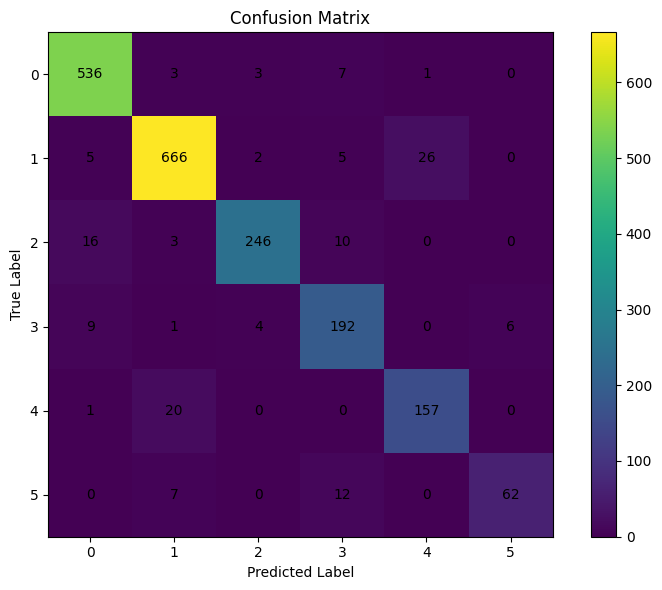

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

# show numbers inside cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


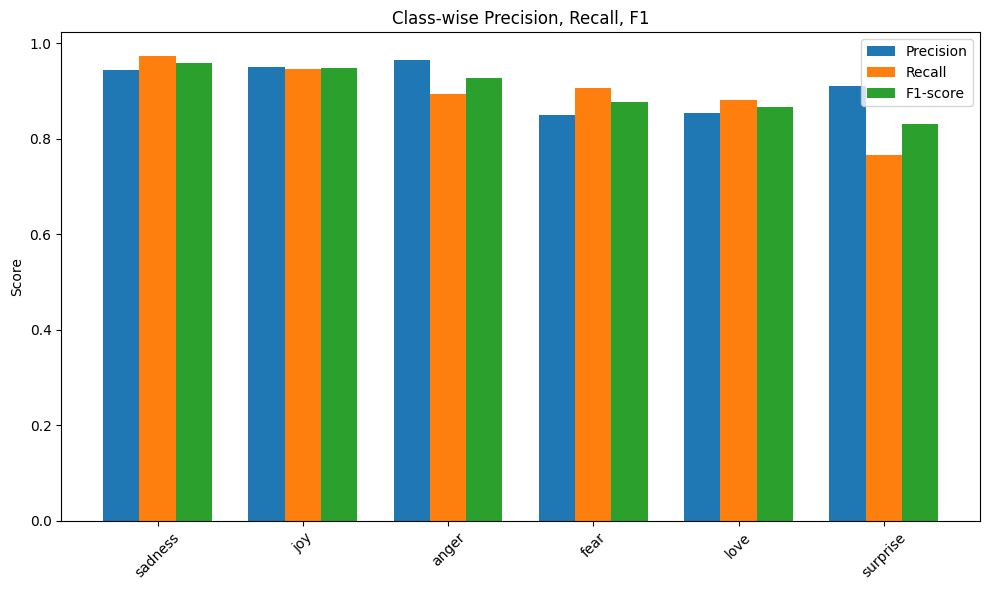

In [ ]:
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True
)

labels = class_names
precisions = [report[label]["precision"] for label in labels]
recalls = [report[label]["recall"] for label in labels]
f1s = [report[label]["f1-score"] for label in labels]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precisions, width, label="Precision")
plt.bar(x, recalls, width, label="Recall")
plt.bar(x + width, f1s, width, label="F1-score")

plt.xticks(x, labels, rotation=45)
plt.ylabel("Score")
plt.title("Class-wise Precision, Recall, F1")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


In [ ]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

accuracy = accuracy_score(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)

print("Accuracy:", round(accuracy, 4))
print("Kappa   :", round(kappa, 4))


Accuracy: 0.9295
Kappa   : 0.9072


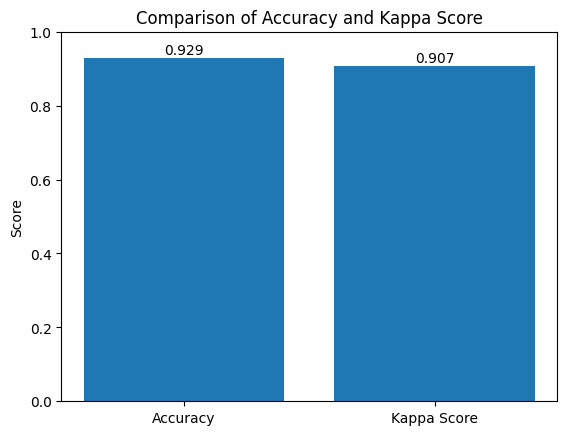

In [ ]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Kappa Score"]
values = [accuracy, kappa]

plt.figure()
plt.bar(metrics, values)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Comparison of Accuracy and Kappa Score")

# show values on top
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")

plt.show()


In [ ]:
train_losses = []
val_accuracies = []


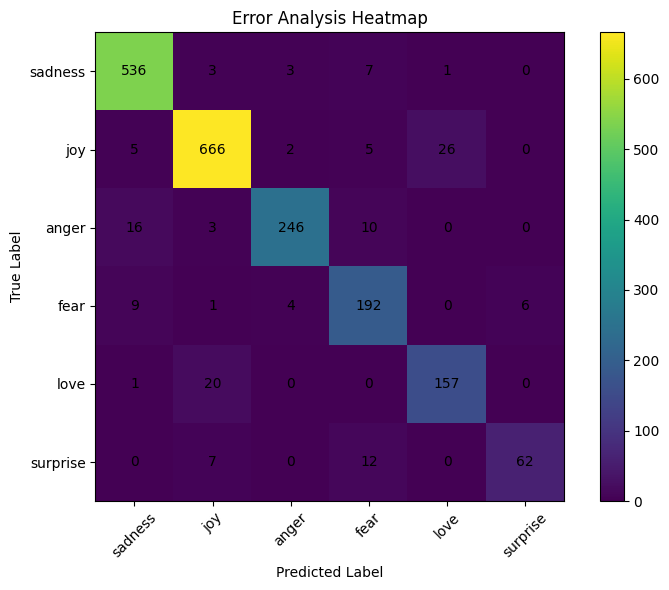

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.imshow(cm)
plt.title("Error Analysis Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

# show values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


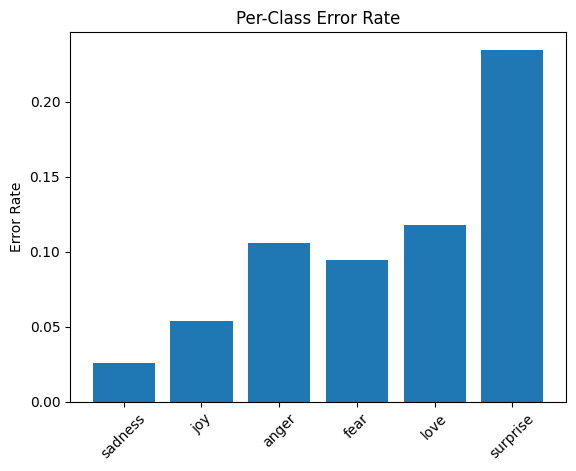

In [ ]:
errors = []
for i in range(len(cm)):
    total = cm[i].sum()
    correct = cm[i][i]
    error_rate = 1 - (correct / total)
    errors.append(error_rate)

plt.figure()
plt.bar(class_names, errors)
plt.ylabel("Error Rate")
plt.title("Per-Class Error Rate")
plt.xticks(rotation=45)
plt.show()


In [ ]:
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

max_error = np.max(cm_no_diag)
i, j = np.where(cm_no_diag == max_error)

print(f"Most confused classes: '{class_names[i[0]]}' → '{class_names[j[0]]}' ({max_error} samples)")


Most confused classes: 'joy' → 'love' (26 samples)


In [ ]:
# Example data (replace with your actual values if saved)
train_losses = [1.58, 0.95]      # training loss per epoch
val_accuracies = [0.89, 0.9295]  # validation accuracy per epoch

epochs_range = range(1, len(train_losses) + 1)


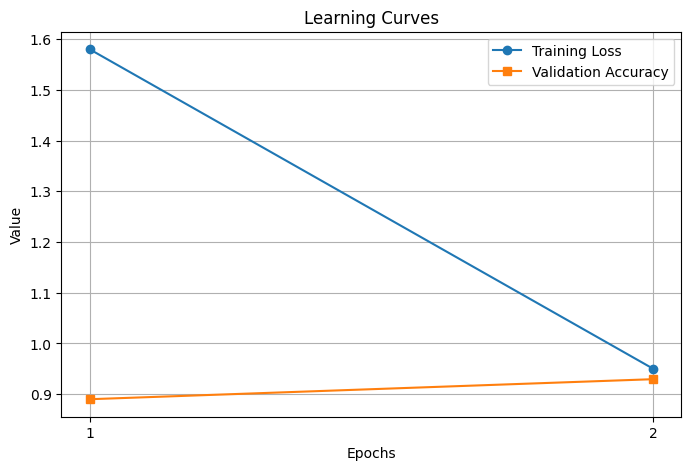

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, marker='o', label="Training Loss")
plt.plot(epochs_range, val_accuracies, marker='s', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Learning Curves")
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)
plt.show()
